In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


## Data Processing 

In [11]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.boston_housing.load_data()
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

#Normalization
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)
X_train = (X_train-X_mean)/X_std
X_test = (X_test-X_mean)/X_std

dim_target = 12 #0~12 사이의 값 5, 12

# X_train_1D = X_train[:, dim_target]
# X_test_1D = X_test[:, dim_target]
#위처럼 정의하면 이후 tf.matmul에 인자로 들어갔을 때 에러가 뜸. 따라서 아래처럼 입력해줘야 함.(어떤 에러메시지 뜨는지 확인 / 위아래 다르게 정의했을 때 각각 shape 뽑아서 확인해볼것)
X_train_1D = tf.expand_dims(X_train[:,dim_target],axis=1)
X_test_1D = tf.expand_dims(X_test[:,dim_target],axis=1)
Y_train_1D = tf.expand_dims(Y_train,axis=1)
Y_test_1D = tf.expand_dims(Y_test, axis=1)
print(X_train_1D.shape)
print(X_test_1D.shape)

(404, 13)
(404,)
(102, 13)
(102,)
(404, 1)
(102, 1)


## Define plot function

In [8]:
def plot_graph(X,Y,X_hat=None,Y_hat=None,str_title=None):
    fig = plt.figure(figsize=(8,6))
    
    if str_title is not None :
        plt.title(str_title,fontsize=20, pad=20)
        
    plt.plot(X,Y, ls='none', marker='o')
    if X_hat is not None and Y_hat is not None:
        plt.plot(X_hat, Y_hat)
        
    plt.tick_params(axis='both',labelsize=14)

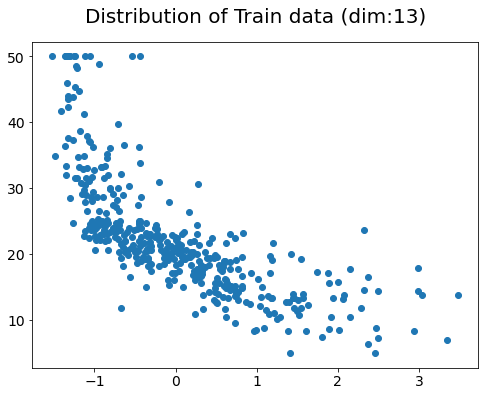

In [9]:
plot_graph(X_train_1D, Y_train, str_title = 'Distribution of Train data (dim:{})'.format(dim_target+1))


### 최적의 파라미터 (weight) $\boldsymbol{w}^*$ 찾기

#### Least Square 혹은 Maximum Likelihood Estimation  방식으로 계산했을 때, $\boldsymbol{w}^*=(\boldsymbol{X}^\top\boldsymbol{X})^{-1}\boldsymbol{X}^\top\boldsymbol{y}$ 이다.

In [13]:
Xmat_T_Xmat = tf.matmul(tf.transpose(X_train_1D),X_train_1D)
weight = tf.matmul(
            tf.matmul(
                tf.linalg.inv(Xmat_T_Xmat),
                tf.transpose(X_train_1D)
            ),
#             Y_train)    #왼쪽처럼 넣어주면 메트리스가 아니라는 에러가 뜸. 따라서 아래처럼 입력해줘야 함. (전후 shape 뽑아서 확인해볼것)
             Y_train_1D)
print(weight.shape)
print(weight)

(1, 1)
tf.Tensor([[-6.72258852]], shape=(1, 1), dtype=float64)


#### Least Square Error , 즉, Loss는 $\frac{1}{2}\sum_{n=1}^{N}\left(y_n-\boldsymbol{w}^\top\phi(\boldsymbol{x}_n)\right)^2 = \frac{1}{2}\sum_{n=1}^{N}\left(y_n-\hat{y}_n\right)^2$ where $\hat{y}=\boldsymbol{Xw}$ 이다.

In [16]:
#RMSE (Root mean square error)
#loss = tf.math.sqrt(tf.reduce_mean((Y_test-tf.matmul(X_test_1D,weight))**2)).numpy()
# 위와 같이 정의하면 정확한 loss 값을 계산할 수 없다.
# Y_test의 shape은 [102]이고 tf.matmul(X_test_1D,weight)의 shape은 [102, 1]이기 때문에 broadcasting이 돼서
loss = tf.math.sqrt(tf.reduce_mean((Y_test-tf.squeeze(tf.matmul(X_test_1D,weight)))**2)).numpy()
print(loss)

23.4293024538165


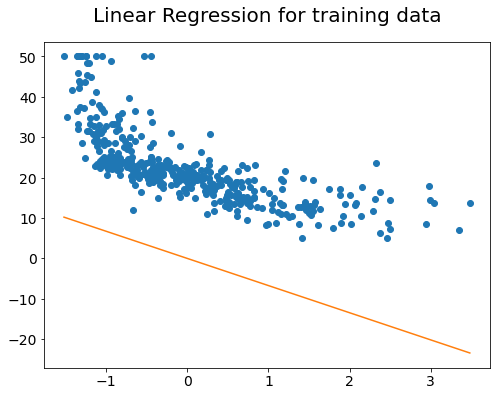

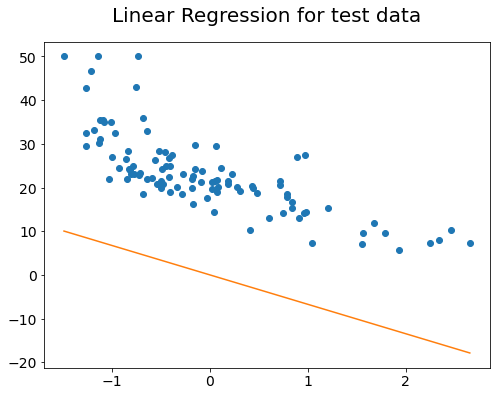

In [17]:
# Xtrain_for_line = np.linspace(np.min(X_train_1D), np.max(X_train_1D), 100)
# Xtest_for_line = np.linspace(np.min(X_test_1D), np.max(X_test_1D), 100)
#위처럼 정의하면 이후 tf.matmul에 인자로 들어갔을 때 에러가 뜸. 따라서 아래처럼 입력해줘야 함.(어떤 에러메시지 뜨는지 확인 / 위아래 다르게 정의했을 때 각각 shape 뽑아서 확인해볼것)
X_train_for_line = np.expand_dims(np.linspace(np.min(X_train_1D),np.max(X_train_1D),100),axis=1)
X_test_for_line = np.expand_dims(np.linspace(np.min(X_test_1D),np.max(X_test_1D),100),axis=1)

plot_graph(X_train_1D, Y_train,
          X_hat = X_train_for_line,
          Y_hat = tf.matmul(X_train_for_line,weight),
          str_title = 'Linear Regression for training data')
plot_graph(X_test_1D, Y_test,
          X_hat = X_test_for_line,
          Y_hat = tf.matmul(X_test_for_line,weight),
          str_title = 'Linear Regression for test data')

### feature function 사용해서 보다 표현력이 높은 linear regression 진행하기

$X=\begin{bmatrix} 1 \\ x \\ \vdots \\ x^N \end{bmatrix}$와 degree $d$를 input으로 받아, $\Phi=\begin{bmatrix} 1 & x_1 & \cdots & x_1^d \\ 1 & x_2 & \cdots & x_2^d \\ \vdots & \vdots & \ddots & \vdots \\ 1 & x_N & \cdots & x_N^d \\ \end{bmatrix}$인 행렬을 output으로 하는 함수 "feature_f" 정의

예를 들어, feature_f$(\begin{bmatrix} 1 \\ x \\ \vdots \\ x^N \end{bmatrix}, 3)= \begin{bmatrix} 1 & x_1 & x_1^2 & x_1^3 \\ 1 & x_2 & x_2^2 & x_2^3 \\ \vdots & \vdots & \vdots & \vdots \\ 1 & x_N & x_N^2 & x_N^3 \\ \end{bmatrix}$.

In [18]:
#주어진 X값을 가지고 Phi를 만드는 함수 정의
def feature_f(X, degree):
    num_X = tf.shape(X)[0]
#     Phi = tf.ones([num_X, 1]) #왼쪽처럼 정의하면 이후 weight_f 구하는 matmul 과정에서 data type 달라서 에러 발생. 따라서 아래처럼 입력해줘야 함. (에러메세지 확인해볼것)
    Phi = tf.ones([num_X, 1],dtype=tf.dtypes.float64) #degree=0일 때 Phi
    
    for i in range (0,degree):
        #degree가 1씩 증가할 때마다 [[x_1^(degree)], [x_2^(degree)], ... , [x_N^(degree)]] 형태의 column이 이전 매트릭스에 추가된다고 볼 수 있다.
        #따라서, degree-1일때의 Phi(즉, feature_f(X, degree-1)에 [[x_1^(degree)], [x_2^(degree)], ... , [x_N^(degree)]]를 "concat"함수를 통해 붙여준다.
        Phi = Phi * X 
        if i == degree-1:
            Phi = tf.concat([feature_f(X, degree-1),Phi],axis=1)
            
    return Phi

In [19]:
num_degree = 3

Phi_train = feature_f(X_train_1D, num_degree)
Phi_test = feature_f(X_test_1D, num_degree)
Phi_Xtrain_for_line = feature_f(X_train_for_line, num_degree)
Phi_Xtest_for_line = feature_f(X_test_for_line, num_degree)

Phi_T_Phi = tf.matmul(tf.transpose(Phi_train),Phi_train)
weight_f = tf.matmul(
                tf.matmul(
                    tf.linalg.inv(Phi_T_Phi),
                    tf.transpose(Phi_train)
                ),
                tf.expand_dims(Y_train,axis=1)
)

loss = tf.math.sqrt(tf.reduce_mean((Y_test-tf.squeeze(tf.matmul(Phi_test,weight_f)))**2)).numpy()
print(loss)

5.683888444002615


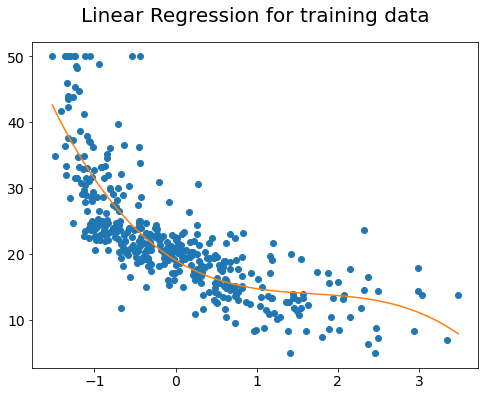

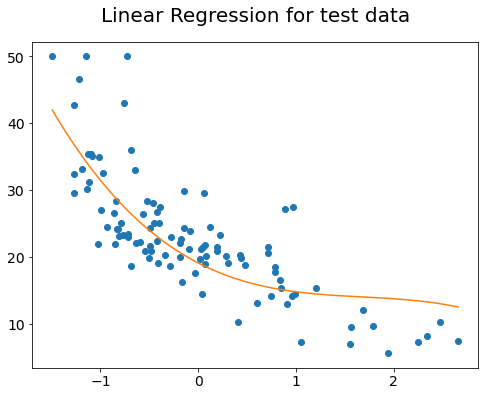

In [20]:
plot_graph(X_train_1D, Y_train,
          X_hat = X_train_for_line,
          Y_hat = tf.matmul(Phi_Xtrain_for_line,weight_f),
          str_title = 'Linear Regression for training data')
plot_graph(X_test_1D, Y_test,
          X_hat = X_test_for_line,
          Y_hat = tf.matmul(Phi_Xtest_for_line,weight_f),
          str_title = 'Linear Regression for test data')

In [21]:
# 1번 방식 (수업에서는 2번 방식 사용. 1번 방식 궁금하면 주석 해제해서 확인)
# weight_gd = tf.Variable(tf.random_normal_initializer(stddev=1)(weight_f.shape))
# # weight_gd = tf.Variable(tf.random_normal_initializer(stddev=1)(weight_f.shape),dtype=tf.dtypes.float64) #요렇게 type 변경이 안됨, 그래서 위처럼 정의하고 아래처럼 얘랑 matmul할꺼 다 타입 변경해줘야함
# Phi_train = tf.cast(Phi_train, dtype=tf.dtypes.float32)
# Phi_test = tf.cast(Phi_test, dtype=tf.dtypes.float32)
# Phi_Xtrain_for_line = tf.cast(Phi_Xtrain_for_line, dtype=tf.dtypes.float32)
# Phi_Xtest_for_line = tf.cast(Phi_Xtest_for_line, dtype=tf.dtypes.float32)

#2번 방식
(H,W) = weight_f.shape
weight_gd = tf.Variable(np.random.randn(H,W),dtype=tf.dtypes.float64)

def RMSE(y_pred, y_true):
    return tf.math.sqrt(tf.reduce_mean(tf.square(tf.squeeze(y_pred) - y_true)))

In [22]:
learning_rate = 0.001
optimizer = tf.optimizers.SGD(learning_rate) # optimizer 정의, Stochastic Gradient Descent를 쓴다는 의미에서 SGD.
                                             # 보다 다양한 optimizer의 종류는 추후 배울 것

def run_optimization():
    with tf.GradientTape() as g: # GradientTape, 즉, g에 loss 계산 과정 저장. why? weight_gd와 loss 사이의 관계를 알아야 weight_gd로 loss 미분이 가능해지기 때문 
        pred = tf.matmul(Phi_train, weight_gd)
        loss = RMSE(pred,Y_train)
        
    gradients = g.gradient(loss, [weight_gd]) # loss를 weight_gd로 미분하고, 미분한 값을 gradients에 저장
    optimizer.apply_gradients(zip(gradients, [weight_gd])) #위에서 계산한 gradients, 즉 미분값을 각 파라미터와 묶어서(zip) 넣어주면
                                                           #해당 셀 첫줄에 정의한 optimizer가 미분값과 learning rate를 이용해 파라미터 업데이트(학습)

In [24]:
training_steps = 30000
display_step = 5000
for step in range(1, training_steps + 1):
    run_optimization()
    
    if step % display_step == 0: # 학습 기다리는 동안 학습이 잘 되고 있는지 확인할 수 있도록 중간과정 출력
        pred = tf.matmul(Phi_train, weight_gd)
        loss = RMSE(pred, Y_train)
        print("step: ", step,", loss: ", loss.numpy(), "weight: ", weight_gd.numpy())

step:  5000 , loss:  15.44879755038492 weight:  [[ 5.12124939]
 [-2.71590808]
 [ 4.3607677 ]
 [-0.95070125]]
step:  10000 , loss:  9.843823615686738 weight:  [[ 9.3575411 ]
 [-4.09588497]
 [ 7.04364481]
 [-1.87283024]]
step:  15000 , loss:  7.093896456539074 weight:  [[12.59461025]
 [-5.07477436]
 [ 8.3306555 ]
 [-2.3262081 ]]
step:  20000 , loss:  6.300750854016212 weight:  [[14.4650851 ]
 [-5.59150463]
 [ 8.25812194]
 [-2.31602568]]
step:  25000 , loss:  5.961243371750243 weight:  [[15.5603546 ]
 [-5.8949982 ]
 [ 7.67170616]
 [-2.12354993]]
step:  30000 , loss:  5.741173082553656 weight:  [[16.31651237]
 [-6.13326941]
 [ 7.02467537]
 [-1.90328049]]


In [25]:
pred = tf.matmul(Phi_test,weight_gd)
loss = RMSE(pred, Y_test).numpy()
print('loss =',loss)

loss = 6.4465347445209575


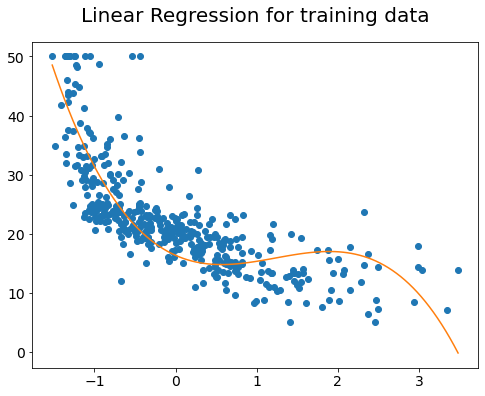

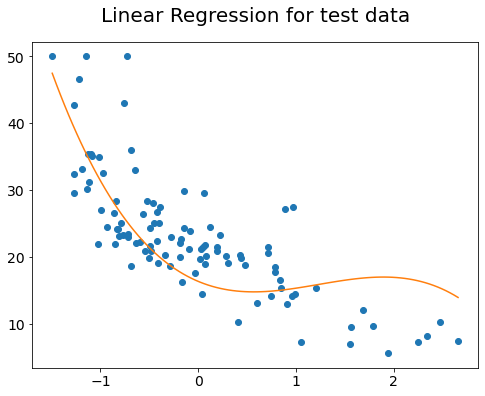

In [26]:
plot_graph(X_train_1D, Y_train,
          X_hat = X_train_for_line,
          Y_hat = tf.matmul(Phi_Xtrain_for_line,weight_gd),
          str_title = 'Linear Regression for training data')

plot_graph(X_test_1D, Y_test,
          X_hat = X_test_for_line,
          Y_hat = tf.matmul(Phi_Xtest_for_line,weight_gd),
          str_title = 'Linear Regression for test data')